In [1]:
import sys
sys.path.append('../src')

import model.solar_radiation.solar_radiation_calculator as calc
from model.solar_radiation.solar_radiation_calculator import Location
import util.time_util as time_util

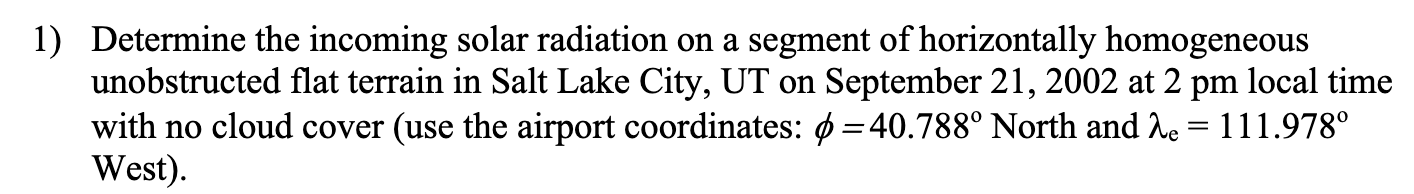

In [2]:
salt_lake_airport = Location(40.788, 111.978, "US/Mountain")
date_time = time_util.make_date_time(year=2002, month=9, day=21, hour=14, timezone=salt_lake_airport.timezone)

incoming_shortwave = calc.calc_radiation_flux(date_time, salt_lake_airport)
print("Incoming solar radiation: {:.2f} W/m^2".format(incoming_shortwave))

Incoming solar radiation: 769.45 W/m^2


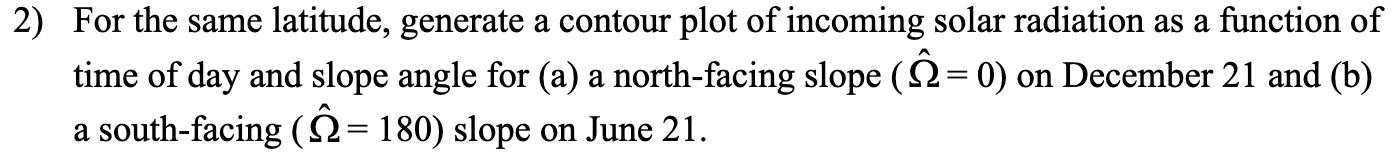

Text(0.5, 1.0, 'North-facing slope')

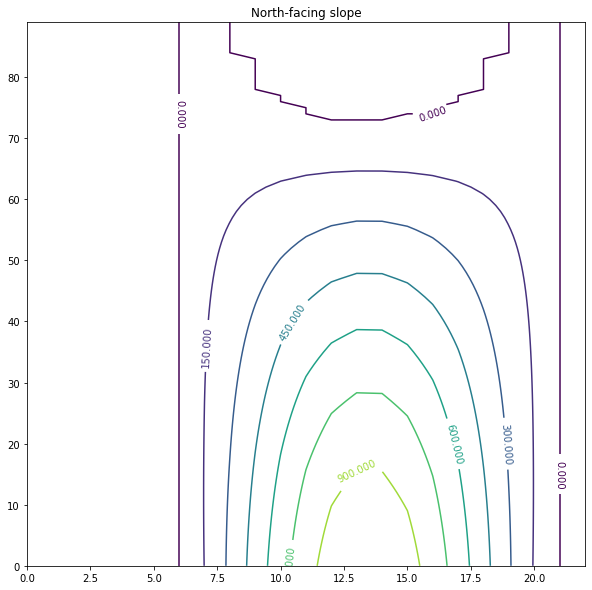

In [3]:
from matplotlib import pyplot as plt

hours = range(0, 23)
angles = range(0, 90)

times = [time_util.make_date_time(month=6, day=21, hour=hour, timezone=salt_lake_airport.timezone) for hour in hours]
incoming_shortwave = [[calc.calc_radiation_flux(date_time, salt_lake_airport, slope_azimuth=0, slope_angle=angle) for date_time in times]
                     for angle in angles]

fig, ax = plt.subplots(figsize=(10,10))
contour_plot = ax.contour(hours, angles, incoming_shortwave)
ax.clabel(contour_plot, inline=1, fontsize=10)
ax.set_title('North-facing slope')

Text(0.5, 1.0, 'South-facing slope')

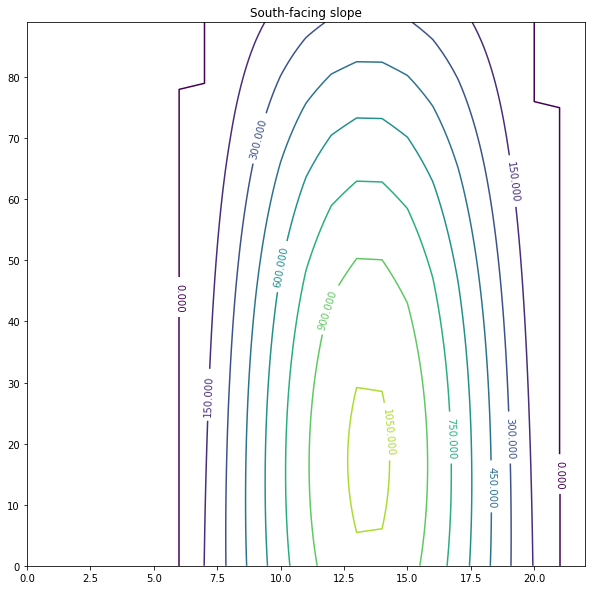

In [4]:
incoming_shortwave = [[calc.calc_radiation_flux(date_time, salt_lake_airport, slope_azimuth=180, slope_angle=angle) for date_time in times]
                     for angle in angles]

fig, ax = plt.subplots(figsize=(10,10))
contour_plot = ax.contour(hours, angles, incoming_shortwave)
ax.clabel(contour_plot, inline=1, fontsize=10)
ax.set_title('South-facing slope')

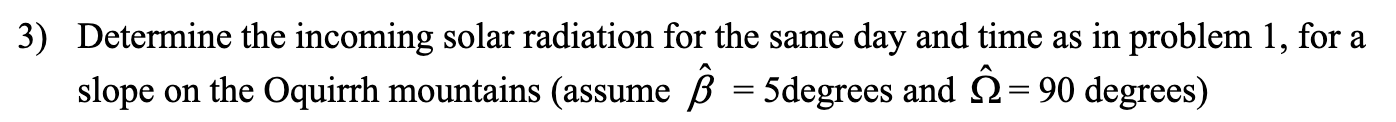

In [5]:
incoming_shortwave = calc.calc_radiation_flux(date_time, salt_lake_airport, slope_angle=5, slope_azimuth=90)
print("Incoming solar radiation: {:.2f} W/m^2".format(incoming_shortwave))

Incoming solar radiation: 754.06 W/m^2


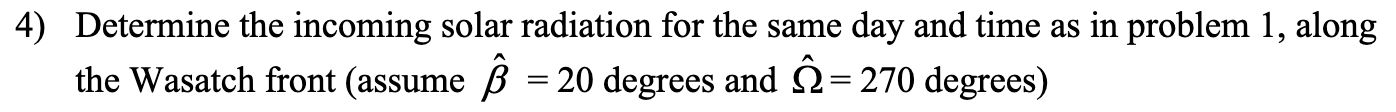

In [6]:
incoming_shortwave = calc.calc_radiation_flux(date_time, salt_lake_airport, slope_angle=20, slope_azimuth=270)
print("Incoming solar radiation: {:.2f} W/m^2".format(incoming_shortwave))

Incoming solar radiation: 771.93 W/m^2


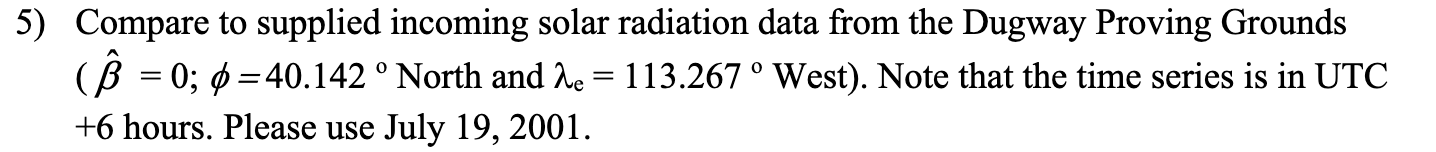

In [11]:
dugway = Location(40.142, 113.267, "US/Mountain") # Mountain Daylight Time is UTC+6
times = [time_util.make_date_time(month=6, day=21, hour=hour, timezone=salt_lake_airport.timezone) for hour in hours]

import pandas as pd

dugway_data = pd.read_csv("../data/raw/dugway.dat", sep="\t", header=4)
dugway_data["Rn"] = dugway_data["Rs down"] - dugway_data["Rs up"]
dugway_data.head()

,Year,Month,Day,Hour,Minute,Second,Decimal Time,Rs down,Rs up,L down,Rn
0,1,7,19,0,0,44,0.012222,-1.23,2.90,405.39,-4.13
1,1,7,19,0,1,44,0.028889,-1.24,2.80,405.52,-4.04
2,1,7,19,0,2,44,0.045556,-1.34,2.67,405.32,-4.01
3,1,7,19,0,3,44,0.062222,-1.47,2.47,405.27,-3.94
4,1,7,19,0,4,44,0.078889,-1.62,2.28,405.50,-3.90


<AxesSubplot:>

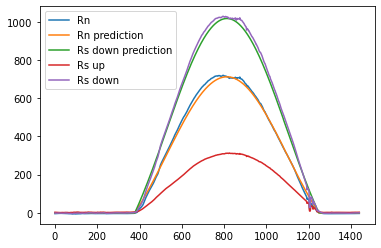

In [19]:
def get_dugway_prediction(row, albedo=0):
    date_time = time_util.make_date_time(year=2001, month=int(row["Month"]), day=int(row["Day"]), 
                                        hour=int(row["Hour"]), minute=int(row["Minute"]), second=int(row["Second"]),
                                        timezone=dugway.timezone)
    return calc.calc_radiation_flux(date_time, dugway, albedo=albedo)

dugway_data["Rs down prediction"] = dugway_data.apply(get_dugway_prediction, axis=1)
dugway_data["Rn prediction"] = dugway_data.apply(lambda x: get_dugway_prediction(x, albedo=.3), axis=1)

dugway_data[["Rn", "Rn prediction", "Rs down prediction", "Rs up", "Rs down"]].plot()

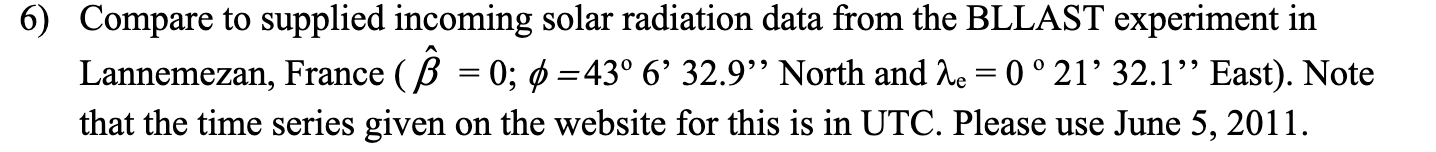

In [35]:
import scipy.io as sio
bllast_data = sio.loadmat("../data/raw/BLLAST_IOP5.mat")
print(bllast_data.keys())
pd.DataFrame.from_records([bllast_data["date"], bllast_data["shortdownward"]])

dict_keys(['__header__', '__version__', '__globals__', 'date', 'shortdownward', 'shortupward', 'rldownwardco', 'rlupwardco'])


,0,1,2,3,4,5,6,7,8,9,...,86390,86391,86392,86393,86394,86395,86396,86397,86398,86399
0,[176.0],[176.0000115741277],[176.000023148139],[176.00003472226672],[176.00004629627801],[176.00005787040573],[176.00006944441702],[176.00008101854473],[176.00009259255603],[176.00010416668374],...,[176.99988425930496],[176.99989583331626],[176.99990740744397],[176.99991898145527],[176.99993055558298],[176.99994212959427],[176.99995370372199],[176.99996527773328],[176.999976851861],[176.9999884258723]
1,[-2.234],[-2.216],[-2.242],[-2.251],[-2.251],[-2.242],[-2.225],[-2.277],[-2.355],[-2.355],...,[-1.373],[-1.364],[-1.329],[-1.399],[-1.451],[-1.46],[-1.486],[-1.46],[-1.434],[-1.347]
